# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Import Packages

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math
import os, glob

## Read in an Image

In [ ]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [ ]:
import os
os.listdir("test_images/")

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

In [6]:
class StableLaneDetector:
    
    left_line  = []
    right_line = []
    
    @classmethod
    def __init__(cls, 
                 kernel_size=5, 
                 low_threshold=50, 
                 high_threshold=150, 
                 rho=1, 
                 theta=np.pi/180, 
                 threshold=25, 
                 min_line_len=20, 
                 max_line_gap=250):
        
        cls.kernel_size = kernel_size
        cls.low_threshold = low_threshold
        cls.high_threshold = high_threshold
        cls.rho = rho
        cls.theta = theta
        cls.threshold = threshold
        cls.min_line_len = min_line_len
        cls.max_line_gap = max_line_gap

    @staticmethod
    def show_image_lst(image_lst, cmap=None):
        cols = 2
        rows = (len(image_lst)+1)//cols

        plt.figure(figsize=(10, 11))
        for i, image in enumerate(image_lst):
            plt.subplot(rows, cols, i+1)
            # use gray scale color map if there is only one channel
            cmap = 'gray' if len(image.shape)==2 else cmap
            plt.imshow(image, cmap=cmap)
            plt.xticks([])
            plt.yticks([])
        plt.tight_layout(pad=0, h_pad=0, w_pad=0)
        plt.show()    
    
    @staticmethod
    def make_grayscale(image):
        return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    @staticmethod    
    def apply_canny(image, low_threshold, high_threshold):
        return cv2.Canny(image, low_threshold, high_threshold)
    
    @staticmethod
    def apply_gaussian_blur(image, kernel_size):
        return cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)
    
    @staticmethod
    def select_region(image, vertices):
        mask = np.zeros_like(image)   
        if len(image.shape) > 2:
            channel_count = image.shape[2]  # i.e. 3 or 4 depending on your image
            ignore_mask_color = (255,) * channel_count
        else:
            ignore_mask_color = 255  
        cv2.fillPoly(mask, vertices, ignore_mask_color)
        masked_image = cv2.bitwise_and(image, mask)
        return masked_image
    
    @staticmethod
    def combine_line_images(line_image, initial_image, α=0.8, β=1., γ=0.):
        init_img = np.copy(initial_image)
        return cv2.addWeighted(init_img, α, line_image, β, γ)
        
    @staticmethod
    def convert_hls(image):
        return cv2.cvtColor(image, cv2.COLOR_RGB2HLS)

    @classmethod
    def mask_white_yellow(cls, image):
        converted = cls.convert_hls(image)
        # white color mask
        lower = np.uint8([  0, 200,   0])
        upper = np.uint8([255, 255, 255])
        white_mask = cv2.inRange(converted, lower, upper)
        # yellow color mask
        lower = np.uint8([ 10,   0, 100])
        upper = np.uint8([ 40, 255, 255])
        yellow_mask = cv2.inRange(converted, lower, upper)
        # combine the mask
        mask = cv2.bitwise_or(white_mask, yellow_mask)
        return cv2.bitwise_and(image, image, mask = mask)

    @staticmethod
    def get_vertices(image):
        '''
        having vertices selected based on proportion of image size 
        NOTE: still not the most reliable, but better than manual setting
        '''
        rows, cols   = image.shape[:2]
        bottom_left  = [cols*0.1, rows*0.95]
        top_left     = [cols*0.4, rows*0.6]
        bottom_right = [cols*0.9, rows*0.95]
        top_right    = [cols*0.6, rows*0.6] 

        vertices = np.array([[bottom_left, top_left, top_right, bottom_right]], dtype=np.int32)
        return vertices

    @staticmethod
    def regression(points):
        '''
        given a list of points, fits a line using regression based on L2 distance
        return slope, intercept of that line
        '''
        [vx,vy,x,y] = cv2.fitLine(points,cv2.DIST_L2,0,0.01,0.01)
        slope = vy / vx 
        intercept = y - (slope * x) 

        return slope[0], intercept[0]

    @staticmethod
    def get_line_points(lines):
        '''
        collects all the line end points from Hough
        store left and right lines in separate lists
        '''
        left_lane_points = []
        right_lane_points = []
        for line in lines:
            if len(line) == 1:
                try:
                    for x1,y1,x2,y2 in line:
                        slope = (y2-y1)/(x2-x1)
                        intercept = y1 - slope*x1
                        if slope < 0:  # since y axis is reverse in images
                            left_lane_points.append([x1,y1])
                            left_lane_points.append([x2,y2])
                        else:
                            right_lane_points.append([x1,y1])
                            right_lane_points.append([x2,y2])
                except Exception as e:
                    pass
        left_lane_points = np.array(left_lane_points)
        right_lane_points = np.array(right_lane_points)
        return left_lane_points, right_lane_points

    @staticmethod
    def hough_transform(image, rho, theta, threshold, min_line_len, max_line_gap):
        lines = cv2.HoughLinesP(image, rho, theta, threshold, np.array([]), 
                                minLineLength=min_line_len, maxLineGap=max_line_gap)
        return lines

    @staticmethod
    def get_regline_endpoints(p1, p2, line, axis='y'):
        '''
        given line slope,intercept calculates X given y (or Y given X)
        p1, p2 must be from same axis (either both y or both x)
        '''
        slope, intercept = line

        if axis == 'y':
            x1 = int((p1 - intercept)/slope)
            x2 = int((p2 - intercept)/slope)
            y1 = int(p1)
            y2 = int(p2)  
        elif axis == 'x':
            y1 = int(p1*slope + intercept)
            y2 = int(p2*slope + intercept)
            x1 = int(p1)
            x2 = int(p2)
        else:
            raise ValueError("axis can be either 'x' or 'y'!")
        return ((x1, y1), (x2, y2))

    @classmethod
    def average_line(cls, line, avg_line):
        if len(avg_line) != 0:
            if 0.8 <= np.abs(line[0]/avg_line[0]) <= 1.2:  # to account for outliers
                avg_line[0] = (avg_line[0] + line[0])/2
                avg_line[1] = (avg_line[1] + line[1])/2
        else:
            avg_line.append(line[0])
            avg_line.append(line[1])
        return avg_line[0], avg_line[1]
         
    @classmethod
    def add_lane_line(cls, image, line):
        y1 = image.shape[0]   # bottom of the image
        y2 = y1*0.6         # slightly lower than the middle
        endpoints = cls.get_regline_endpoints(y1, y2, line)
        cv2.line(image,*endpoints,(255,0,0),10)

    @classmethod
    def process_image(cls, image):
        img_masked = cls.mask_white_yellow(image)
        img_gray   = cls.make_grayscale(img_masked)
        img_blur   = cls.apply_gaussian_blur(img_gray, cls.kernel_size)
        img_edge   = cls.apply_canny(img_blur, cls.low_threshold, cls.high_threshold)
        vertices   = cls.get_vertices(img_edge)
        img_region = cls.select_region(img_edge, vertices)        
        lines      = cls.hough_transform(img_region, 
                                         cls.rho, 
                                         cls.theta, 
                                         cls.threshold, 
                                         cls.min_line_len, 
                                         cls.max_line_gap)
        points_lst = cls.get_line_points(lines)
        
        line_img   = np.zeros_like(image)
        for i, points in enumerate(points_lst):
            line = cls.regression(points)
            if i == 0:
                stable_line = cls.average_line(line, cls.left_line)
            else:
                stable_line = cls.average_line(line, cls.right_line)
            cls.add_lane_line(line_img, stable_line)
            
        final_image = cls.combine_line_images(image, line_img, α=0.8, β=1., γ=0.)
        return final_image

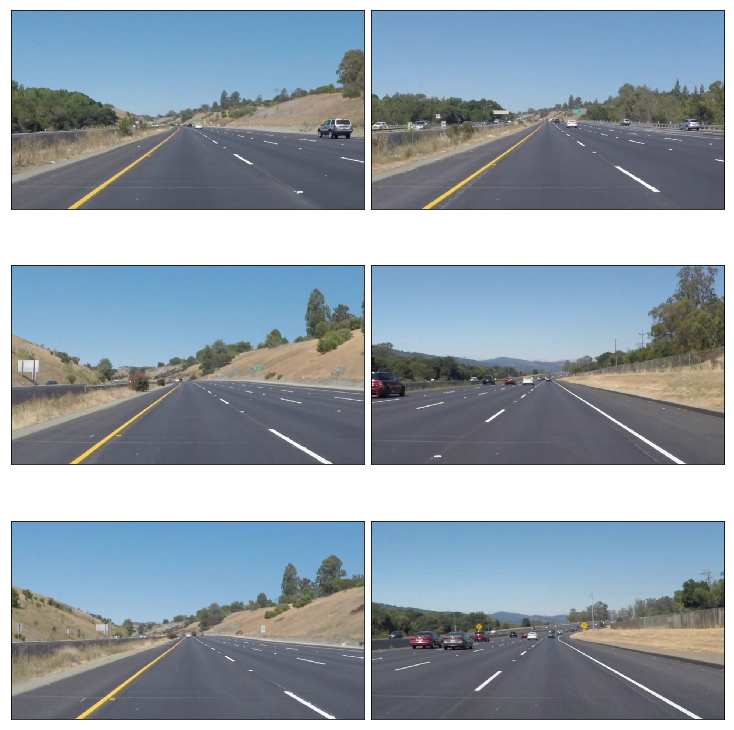

In [7]:
test_images = [plt.imread(path) for path in glob.glob('test_images/*.jpg')]
StableLaneDetector.show_image_lst(test_images)

In [9]:
# TODO: Build your pipeline that will draw lane lines on the test_images
def get_lane_lines_imageList(in_folder, out_folder, kwargs=None):
    '''
    applies lane finding to a list of images
    '''
    for img_fn in os.listdir(in_folder):
        input_pth = os.path.join(in_folder, img_fn)
        img = mpimg.imread(input_pth)
        img_final = StableLaneDetector().process_image(img)
        os.makedirs(out_folder, exist_ok=True)
        output_pth = os.path.join(out_folder, img_fn)
        plt.imsave(output_pth, arr=img_final)
        
get_lane_lines_imageList("test_images", "test_images_output")

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [10]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

Let's try the one with the solid white lane on the right first ...

In [11]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
lane_detector = StableLaneDetector()
white_clip = clip1.fl_image(lane_detector.process_image)
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|█████████▉| 221/222 [00:02<00:00, 82.68it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 2.87 s, sys: 395 ms, total: 3.26 s
Wall time: 3.06 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [12]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [13]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
lane_detector = StableLaneDetector()
yellow_clip = clip2.fl_image(lane_detector.process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|█████████▉| 681/682 [00:09<00:00, 71.87it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 9.9 s, sys: 1.17 s, total: 11.1 s
Wall time: 9.94 s


In [14]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [15]:
challenge_output = 'test_videos_output/challenge.mp4'
clip3 = VideoFileClip('test_videos/challenge.mp4')
lane_detector = StableLaneDetector()
challenge_clip = clip3.fl_image(lane_detector.process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


100%|██████████| 251/251 [00:07<00:00, 32.39it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

CPU times: user 20.7 s, sys: 606 ms, total: 21.3 s
Wall time: 8.65 s


In [16]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))